In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, irfft, ifft
from scipy.linalg import toeplitz
import pylops

In [2]:
def Ricker_Wavelet(Peak_freq, Samples, Dt):
    t = np.arange(Samples)*(Dt/1000)
    t = np.concatenate( (np.flipud(-t[1:]), t), axis=0)
    ricker = (1. -2.*(np.pi**2)*(Peak_freq**2)*(t**2))*np.exp(-(np.pi**2)*(Peak_freq**2)*(t**2))
    return t, ricker

In [3]:
t, ricker = Ricker_Wavelet(30,101,4)

Refl = np.zeros(521)
Refl[100] = 0.2
Refl[230] = -0.15
Refl[340] = 0.05
Refl[270] = -0.08
Refl[145] = 0.1

n = len(Refl)
m = len(ricker)

In [4]:
Refl_T = Refl.reshape(n,1)
ricker_padded = np.append(ricker,np.zeros((1,2*n-m)))

In [5]:
G = toeplitz(400*ricker_padded, np.zeros((1,n)))
G = G[m//2+1:n+(m//2)+1,:]

In [6]:
trace = np.matmul(G, Refl_T)

In [7]:
time = np.linspace(0,1,n)

Text(0, 0.5, 'Time(ms)')

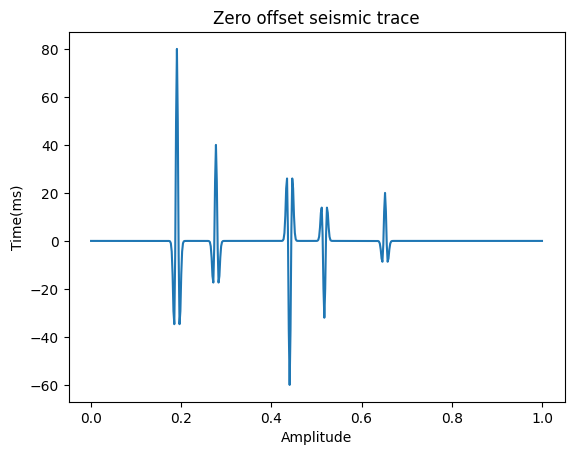

In [8]:
plt.title("Zero offset seismic trace")

plt.plot(time, trace)

plt.xlabel("Amplitude")
plt.ylabel("Time(ms)")

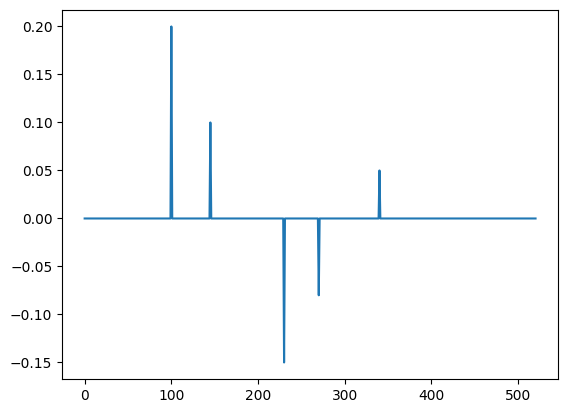

In [9]:
plt.plot(Refl)

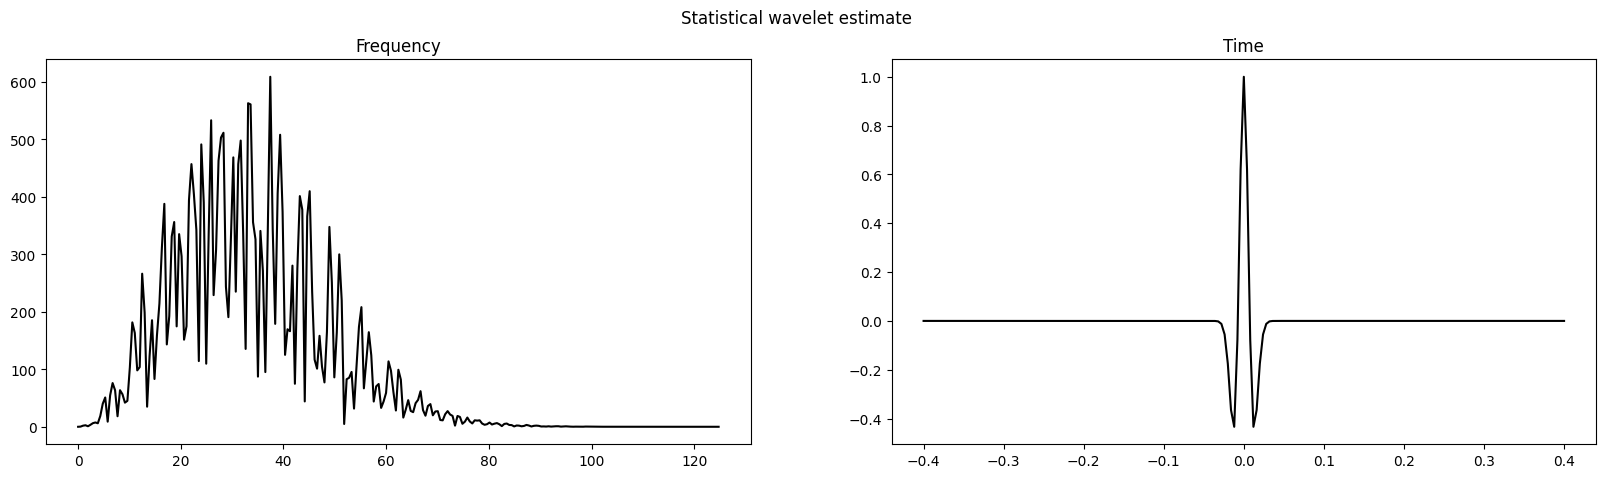

In [21]:
dt = 4
nt = len(trace)


# estimate wavelet spectrum
tsfp = np.fft.rfft(trace.T)
    
freq = np.fft.rfftfreq(nt, d=0.004)
    

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(freq, abs(tsfp.T), 'k')
axs[0].set_title('Frequency')
axs[1].plot(t,ricker, 'k')
axs[1].set_title('Time');

In [23]:
def Pulso_Ricker(Peak_freq, Sample, dt):
    tmax = Sample*(dt)
    deltaf = 1/tmax
    Freq = np.arange(0,Sample/2,1)*deltaf
    Pulse = ((Freq/Peak_freq)**2)*np.exp(-(Freq/Peak_freq)**2)
    return Freq, Pulse

In [40]:
Sample = 521
dt = 0.004
Freq, F = Pulso_Ricker(30, Sample, dt)

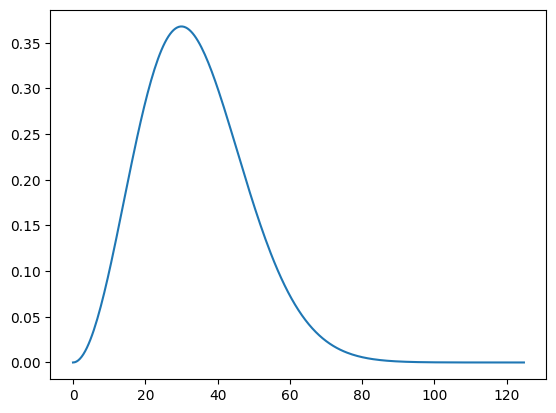

In [41]:
plt.plot(Freq, F)

In [42]:
def MD(F,freq,dt,q):
    k = 521
    f0=1
    j = complex(0,1)
    MMD = np.zeros((len(Freq),k),complex)
    for i in range(len(Freq)):
        if q > 500:
            for v in range(k):
                MMD[i,v] = F[i] * np.exp(-j*2*np.pi*Freq[i]*v*dt)

        else:
            Q=0
            for v in range(1,k):
                Q=Q + (1/q[v])
                a = 1 #dado sintetico
                MMD[i,v]= F[i] * np.exp(-j*2*np.pi*freq[i]*v*dt+(dt*2*np.pi*freq(i))*(a*j*np.log(f0/(freq(i)+.01))-1)*Q)
    return MMD

In [43]:
MMD = MD(F, Freq, dt, 5000000000000)

In [44]:
tsf = np.matmul(MMD,Refl)

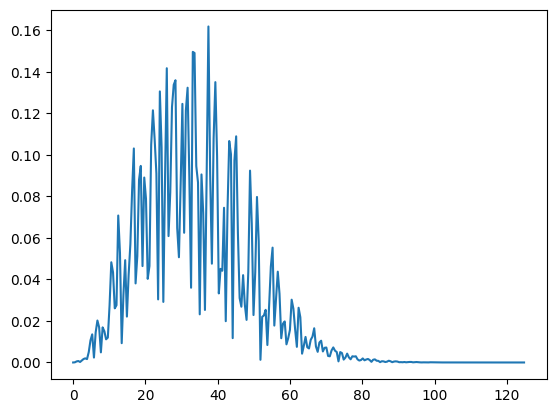

In [45]:
plt.plot(Freq, abs(tsf))

In [46]:
n = len(Refl)
x = np.zeros(n,complex)
x[0:261] = tsf[0:261]

In [47]:
for j in range(round(n/2)+2,n):
    x[j] = np.conjugate(x[np.mod(n-j+1,n)])

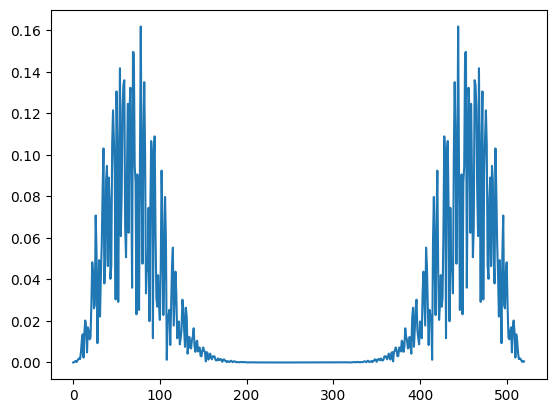

In [70]:
plt.plot(abs(x))

In [71]:
tst = np.fft.irfft(x,521)

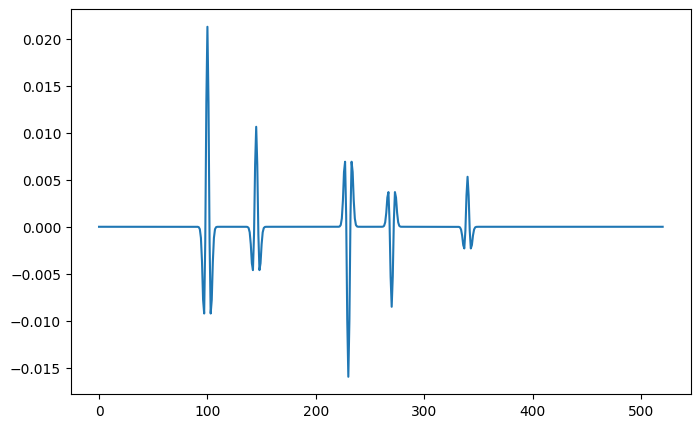

In [72]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
ax1.plot(tst)

In [73]:
def Model(Refl, q, dt, fp):
    
    n = len(Refl)
    
    freq, F = Pulso_Ricker(fp, n, dt)
    
    MMD = MD(F, freq, dt, q)

    
    tsf = np.matmul(MMD,Refl)
    x[0:261] = tsf[0:261]
    
    for j in range(round(n/2)+2,n):
        x[j] = np.conjugate(x[np.mod(n-j+1,n)])

    tst = np.fft.irfft(x, 521)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1.plot(Refl)
    
    ax2.plot(tst)
    

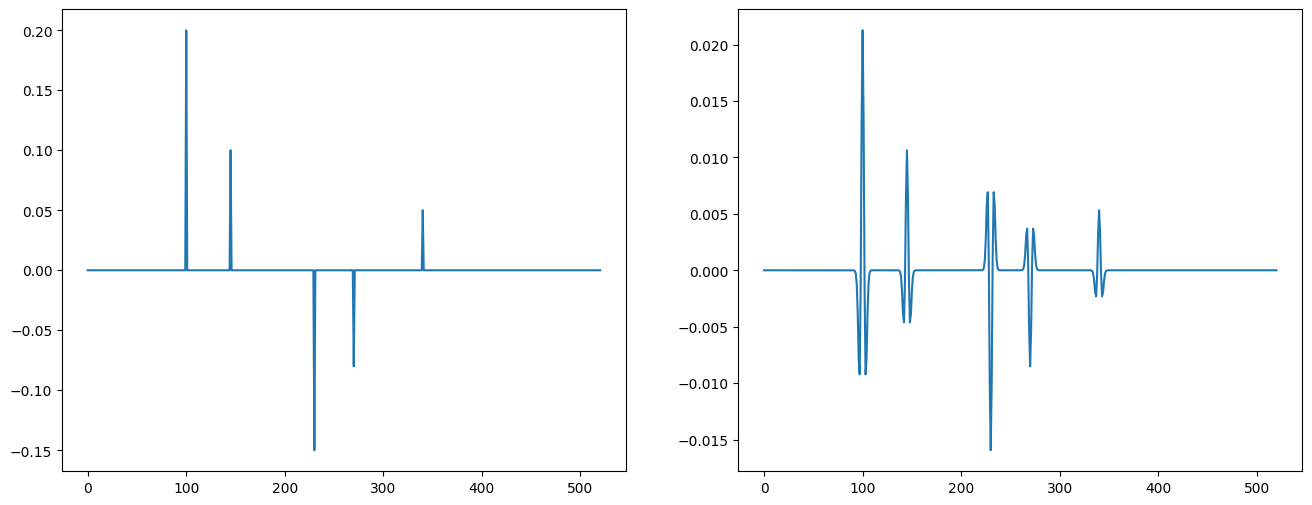

In [74]:
Model(Refl,500000000,dt, 30)

In [75]:
Cop = pylops.signalprocessing.Convolve1D(len(Refl), h=ricker, offset=ricker.tolist().index(ricker.max()), dtype="float32")


In [76]:
y = Cop*Refl

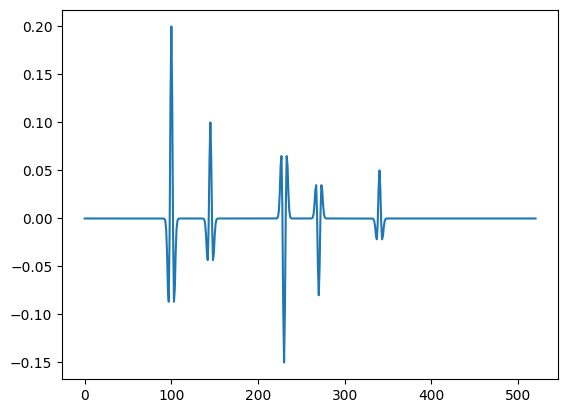

In [77]:
plt.plot(y)

In [78]:
xfista, niterf, costf = pylops.optimization.sparsity.fista(
    Cop,
    y,
    niter=30,
    eps=1e-1,
    tol=1e-5,
)


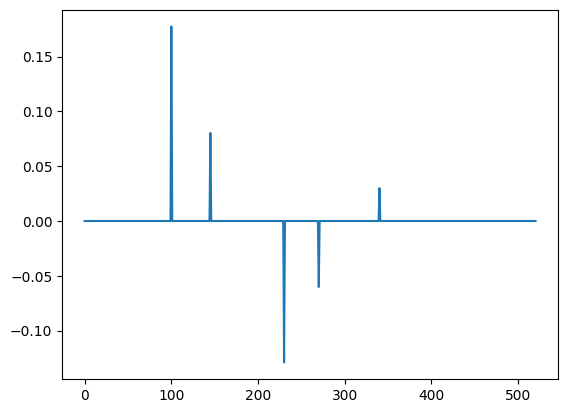

In [79]:
plt.plot(xfista)

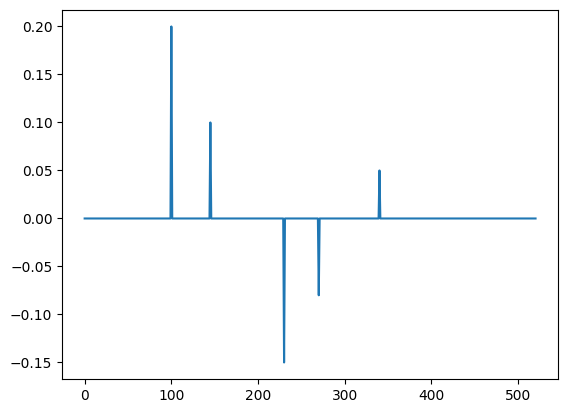

In [80]:
plt.plot(Refl)